# Data-Intensive Applications on HPC Using Hadoop, Spark and RADICAL-Cybertools

*Shantenu Jha and Andre Luckow*

The tutorial material is available as iPython notebook at:

* http://nbviewer.ipython.org/github/radical-cybertools/supercomputing2015-tutorial/blob/master/Tutorial%20Overview.ipynb

The code is published on Github:

* https://github.com/radical-cybertools/supercomputing2015-tutorial

## Requirements and Setup:

Python with the following libraries:

* Numpy
* Pandas
* Scikit-Learn
* Seaborn
* BigJob2

We recommend to use [Anaconda](http://continuum.io/downloads).


## 1. Pilot-Abstraction for distributed HPC and Apache Hadoop Big Data Stack (ABDS)

The Pilot-Abstraction has been successfully used in HPC for supporting a diverse set of task-based workloads on distributed resources. A Pilot-Job is a placeholder job that is submitting to the resource management system and is used as a container for a dynamically determined set of compute tasks. The Pilot-Data abstraction extends the Pilot-Abstraction for supporting the management of data in conjunction with compute tasks. 

### 1.1 Pilot-Abstraction

The Pilot-Abstraction supports a heterogeneous resources, in particular different kinds of cloud, HPC and Hadoop resources.

![Pilot Abstraction](./figures/interoperable_pilot_job.png)

### 1.2 Example

The following example demonstrates how the Pilot-Abstraction is used to manage a set of compute tasks.


In [5]:
%matplotlib inline
import sys, os
import time
import pandas as pd
import seaborn as sns

### 1.2.1 Start Pilot-Job

In [2]:
from pilot import PilotComputeService, ComputeDataService, State
COORDINATION_URL = "redis://EiFEvdHRy3mNBZDjsypraXGNQqJcAYKaTnHCZxgqLsykDoKXb@localhost:6379"

pilot_compute_service = PilotComputeService(coordination_url=COORDINATION_URL)

pilot_compute_description = {
                         "service_url": 'fork://localhost',
                         "number_of_processes": 1,                             
                        }

pilotjob = pilot_compute_service.create_pilot(pilot_compute_description=pilot_compute_description)

Populating the interactive namespace from numpy and matplotlib


BigJob provides various introspection capabilities and allows the application to extract various details on the runtime.

In [8]:
pd.DataFrame(pilotjob.get_details().values(), 
             index=pilotjob.get_details().keys(), 
             columns=["Value"])

,Value
bigjob_id,bigjob:bj-e758d79a-54a3-11e5-99b1-44a842265a41...
description,{'external_queue': 'PilotComputeServiceQueue-p...
start_time,1441549864.24
state,Running
stopped,False
nodes,['localhost\n']
end_queue_time,1441549867.93


In [9]:
compute_unit_description = {
        "executable": "/bin/sleep",
        "arguments": ["0"],
        "number_of_processes": 1,            
        "output": "stdout.txt",
        "error": "stderr.txt",   
}   

compute_unit = pilotjob.submit_compute_unit(compute_unit_description)
compute_unit.wait()

# Print out some statistics about execution
pd.DataFrame(compute_unit.get_details().values(), 
             index=compute_unit.get_details().keys(), 
             columns=["Value"])

,Value
run_host,radical-5
Executable,/bin/sleep
NumberOfProcesses,1
start_time,1441550025.18
agent_start_time,1441549867.93
state,Done
end_time,1441550028.33
Arguments,['0']
Error,stderr.txt
Output,stdout.txt


In [ ]:
pilot_compute_service.cancel()

## 2. Pilot-Hadoop

For the purpose of this tutorial we setup a Hadoop cluster on [Chameleon](https://www.chameleoncloud.org/):

* YARN: http://129.114.108.119:8088/
* HDFS: http://129.114.108.123:50070/
* Ambari: http://129.114.108.119:8080/

### 2.1 Setup Spark on YARN

In [1]:
from numpy import array
from math import sqrt

%run env.py
%run util/init_spark.py

print "SPARK HOME: %s"%os.environ["SPARK_HOME"]

try:
    sc
except NameError:
    conf = SparkConf()
    conf.set("spark.num.executors", "4")
    conf.set("spark.executor.instances", "4")
    conf.set("spark.executor.memory", "5g")
    conf.set("spark.cores.max", "4")
    conf.setAppName("iPython Spark")
    conf.setMaster("yarn-client")
    sc = SparkContext(conf=conf)
    sqlCtx = SQLContext(sc)

SPARK HOME: /usr/hdp/2.3.0.0-2557/spark/


In [27]:
rdd = sc.parallelize(range(10))

In [28]:
rdd.map(lambda a: a*a).collect()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

## 3. KMeans

This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant (see <https://archive.ics.uci.edu/ml/datasets/Iris>). 

Source: R. A. Fisher, The Use of Multiple Measurements in Taxonomic Problems, 1936, http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf

Pictures (Source [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set))

<table>
<tr><td>
Setosa
</td><td>
Versicolor
</td><td>
Virginica
</td></tr>
<tr><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/180px-Kosaciec_szczecinkowaty_Iris_setosa.jpg"/> 
</td><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/320px-Iris_versicolor_3.jpg"/>
</td><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/295px-Iris_virginica.jpg"/>
</td></tr></table>

## 3.1 Load Data 

In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/pydata/pandas/master/pandas/tests/data/iris.csv")

In [7]:
data.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


The following pairplots show the scatter-plot between each of the four features. Clusters for the different species are indicated by the color.

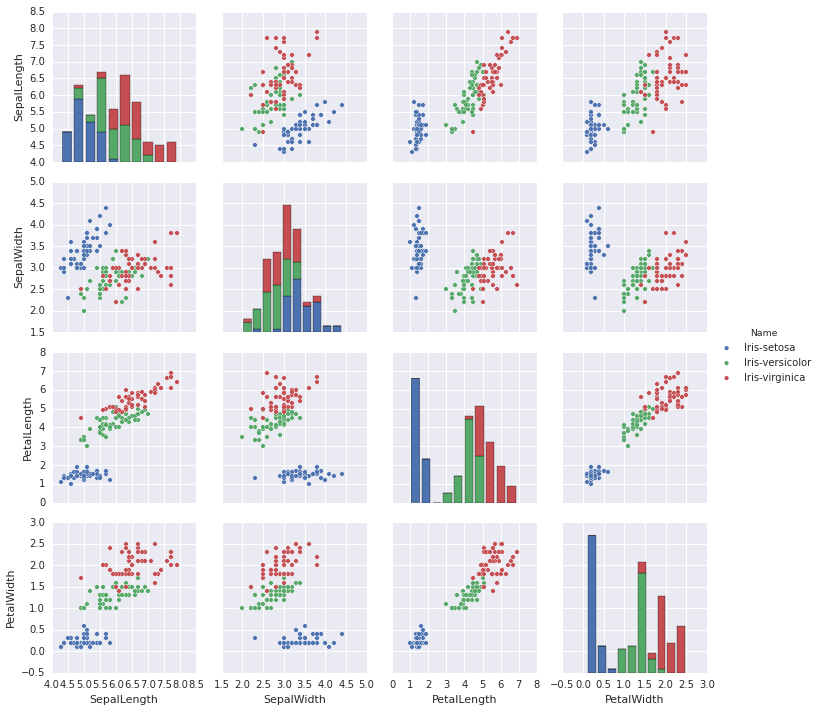

In [4]:
sns.pairplot(data, vars=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"], hue="Name");

## 3.2 KMeans (Scikit)


In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
results = kmeans.fit_predict(data[['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']])

In [8]:
data_kmeans=pd.concat([data, pd.Series(results, name="ClusterId")], axis=1)
data_kmeans.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name,ClusterId
0,5.1,3.5,1.4,0.2,Iris-setosa,1
1,4.9,3.0,1.4,0.2,Iris-setosa,1
2,4.7,3.2,1.3,0.2,Iris-setosa,1
3,4.6,3.1,1.5,0.2,Iris-setosa,1
4,5.0,3.6,1.4,0.2,Iris-setosa,1


#### Evaluate Quality of Model

In [17]:
print "Sum of squared error: %.1f"%kmeans.inertia_

Sum of squared error: 78.9


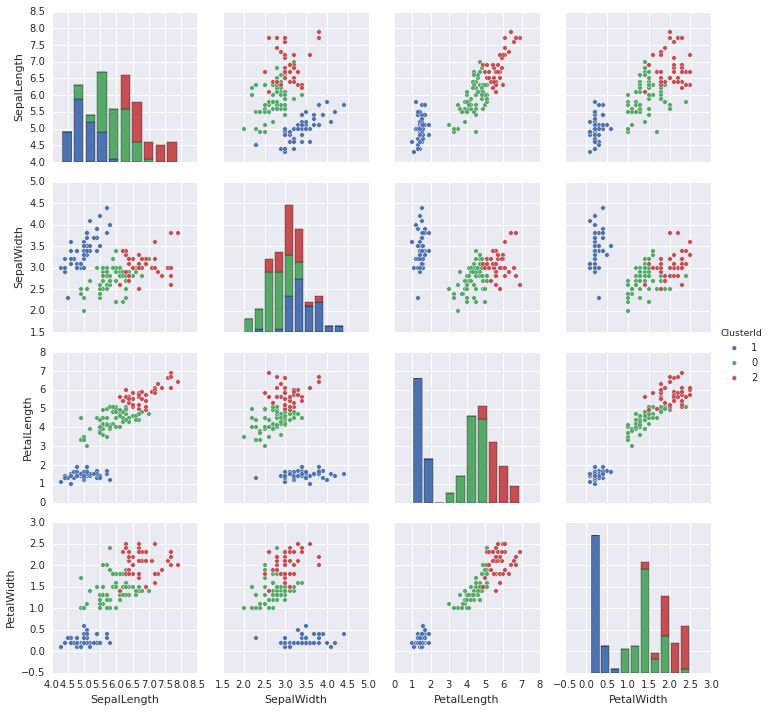

In [12]:
sns.pairplot(data_kmeans, vars=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"], hue="ClusterId");

## 3.3 KMeans (Spark)

https://spark.apache.org/docs/latest/mllib-clustering.html#k-means

In [8]:
data_spark=sqlCtx.createDataFrame(data)

In [16]:
data_spark_without_class=data_spark.select('SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth').show()

SepalLength SepalWidth PetalLength PetalWidth
5.1         3.5        1.4         0.2       
4.9         3.0        1.4         0.2       
4.7         3.2        1.3         0.2       
4.6         3.1        1.5         0.2       
5.0         3.6        1.4         0.2       
5.4         3.9        1.7         0.4       
4.6         3.4        1.4         0.3       
5.0         3.4        1.5         0.2       
4.4         2.9        1.4         0.2       
4.9         3.1        1.5         0.1       
5.4         3.7        1.5         0.2       
4.8         3.4        1.6         0.2       
4.8         3.0        1.4         0.1       
4.3         3.0        1.1         0.1       
5.8         4.0        1.2         0.2       
5.7         4.4        1.5         0.4       
5.4         3.9        1.3         0.4       
5.1         3.5        1.4         0.3       
5.7         3.8        1.7         0.3       
5.1         3.8        1.5         0.3       


### Convert DataFrame to Tuple for MLlib

In [30]:
data_spark_tuple = data_spark.map(lambda a: (a[0],a[1],a[2],a[3]))

### Run MLlib KMeans

In [31]:
# Build the model (cluster the data)
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters = KMeans.train(data_spark_tuple, 3, maxIterations=10,
                        runs=10, initializationMode="random")

### Evaluate Model

In [34]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = data_spark_tuple.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 97.3259242343


## 4. Graph Analysis
### 4.1 Load Data

In [43]:
import networkx as NX

In [38]:
graph_data = pd.read_csv("https://raw.githubusercontent.com/drelu/Pilot-KMeans/master/data/mdanalysis/small/graph_edges_95_215.csv",
                        names=["Source", "Destination"])

In [39]:
graph_data.head()

,Source,Destination
0,0,0
1,0,67
2,0,14
3,1,1
4,1,41


In [53]:
nxg = NX.from_edgelist(list(graph_data.to_records(index=False)))

### 4.2 Plot Graph

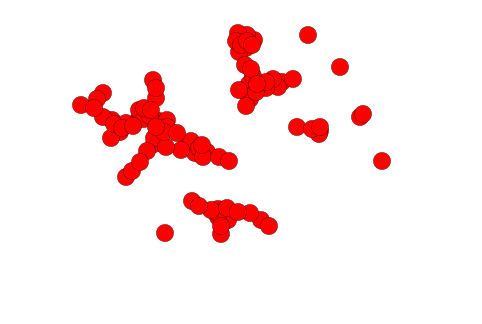

In [54]:
NX.draw(nxg, pos=NX.spring_layout(nxg))

### 4.3 Analytics

#### Degree Histogram

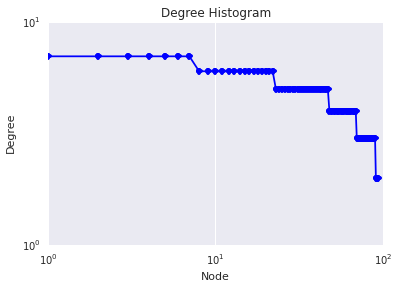

In [52]:
import matplotlib.pyplot as plt
degree_sequence=sorted(NX.degree(nxg).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
#print "Length: %d" % len(degree_sequence)
dmax=max(degree_sequence)
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree Histogram")
plt.ylabel("Degree")
plt.xlabel("Node")

## 5. Future Work: Midas

![Midas](figures/midas.png)
